In [1]:
from eda_functions import *
from fit_and_score_model import *
from nlp_functions import *

import pandas as pd
import numpy as np

import spacy
import collections
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.text import Text
from wordcloud import WordCloud
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
import xgboost
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix      

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data = pd.read_csv('data/train.tsv', sep='\t', header=None)
test_data = pd.read_csv('data/test.tsv', sep='\t', header=None)

In [3]:
df = pd.concat([train_data, test_data], axis=0)

In [4]:
df = df.drop(columns=[2])

In [5]:
df.columns = ['comment', 'emotions']

In [6]:
dataframe_overview(df)

I̲N̲F̲O̲ 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 48837 entries, 0 to 5426
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comment   48837 non-null  object
 1   emotions  48837 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB
None


H̲E̲A̲D̲ 
                                             comment emotions
0  My favourite food is anything I didn't have to...       27
1  Now if he does off himself, everyone will thin...       27
2                     WHY THE FUCK IS BAYLESS ISOING        2
3                        To make her feel threatened       14
4                             Dirty Southern Wankers        3


S̲H̲A̲P̲E̲ 
(48837, 2)


C̲O̲L̲U̲M̲N̲S̲ 
['comment', 'emotions']


C̲O̲L̲U̲M̲N̲ ̲S̲T̲A̲T̲S̲ 
           comment emotions
count        48837    48837
unique       48616      741
top     Thank you.       27
freq            14    14429


T̲O̲T̲A̲L̲ ̲D̲U̲P̲L̲I̲C̲A̲T̲E̲ ̲R̲O̲W̲S̲ 
 142


#### Multi-label to Single-label

In [7]:
single_label = []
for multi_label in df['emotions']:
    single_label.append(multi_label.split(',')[0])

In [8]:
single_label_series = pd.Series(single_label)

In [9]:
df['emotion'] = single_label_series

In [10]:
df = df.drop(columns=['emotions'])

#### Consolidate Labels

Label Key
<br>
<br>
0 admiration <br>
1 amusement <br>
2 anger <br>
3 annoyance <br>
4 approval <br>
5 caring <br>
6 confusion <br>
7 curiosity <br>
8 desire <br>
9 disappointment <br>
10 disapproval <br>
11 disgust <br>
12 embarrassment <br>
13 excitement <br>
14 fear <br>
15 gratitude <br>
16 grief <br>
17 joy <br>
18 love <br>
19 nervousness <br>
20 optimism <br>
21 pride <br>
22 realization <br>
23 relief <br>
24 remorse <br>
25 sadness <br>
26 surprise <br>
27 neutral


In [11]:
df.loc[df['emotion'].isin(['3', '11', '14', '2']), 'emotion'] = 'Anger'

In [12]:
df.loc[df['emotion'].isin(['6', '12', '19', '22', '26', '13']), 'emotion'] = 'Excitement'

In [13]:
df.loc[df['emotion'].isin(['1', '20', '21', '23', '17']), 'emotion'] = 'Joy'

In [14]:
df.loc[df['emotion'].isin(['0', '4', '5', '8', '15', '18']), 'emotion'] = 'Love'

In [15]:
df.loc[df['emotion'].isin(['7', '27']), 'emotion'] = 'Neutral'

In [16]:
df.loc[df['emotion'].isin(['9', '10', '16', '24', '25']), 'emotion'] = 'Sadness'

# Text Cleaning

#### Raw Corpus

In [17]:
raw_corpus = ''
for comment in df['comment']:
    raw_corpus += ''.join(comment) + ' '

#### Stopwords

In [18]:
StopWords = set(stopwords.words('english'))
additional_stopwords = {'thing', 'think', 'would', 'get', 'th', 'nt', 'go', 'name', 'I', 'man', 'one', 'oh'}
StopWords = custom_stopwords(StopWords, additional_stopwords)

#### Text Cleaning Pipeline

In [19]:
def text_cleaning_pipeline(text, stop_words=StopWords):
    '''
    A text cleaning pipeline to clean a string of text by spellchecking, lowercasing, removing numbers/puncuation/new lines/urls/stopwords and lemmatizing.

    Parameters
    ----------
    text:  str 
        The text to be cleaned.
    
    stop_words:  set
        Set of stopwords to remove.
    
    Returns
    ----------
    String of the cleaned text.
    '''
    text_tb = TextBlob(text)
    text_sp = text_tb.correct()
    text_lc = lowercase_text(text_sp)
    text_np = remove_nums_and_punctuation(text_lc)
    text_nnls = remove_newlines(text_np)
    text_nurl = remove_urls(str(text_nnls))
    text_lemd = lemmatize_string(text_nurl)
    words = string_to_word_list(text_lemd)
    words_nsw = remove_stopwords(words, stop_words)
    cleaned_str = word_list_to_string(words_nsw)
    return cleaned_str

In [20]:
df['comment'] = df['comment'].apply(text_cleaning_pipeline)

In [21]:
df = df.drop_duplicates(subset='comment')

#### Cleaned Corpus

In [22]:
cleaned_corpus = ''
for comment in df['comment']:
    cleaned_corpus += ''.join(comment) + ' '

# Analyze and Improve Model

#### Dataframe Overview

In [23]:
dataframe_overview(df)

I̲N̲F̲O̲ 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 46158 entries, 0 to 5426
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  46158 non-null  object
 1   emotion  46158 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB
None


H̲E̲A̲D̲ 
                                             comment  emotion
0                       favourite food anything cook  Neutral
1  everyone laugh screw people instead actually dead  Neutral
2                                  fuck bayless isoe    Anger
3                                 make feel threaten    Anger
4                              dirty southern banker    Anger


S̲H̲A̲P̲E̲ 
(46158, 2)


C̲O̲L̲U̲M̲N̲S̲ 
['comment', 'emotion']


C̲O̲L̲U̲M̲N̲ ̲S̲T̲A̲T̲S̲ 
       comment  emotion
count    46158    46158
unique   46158        6
top             Neutral
freq         1    15494


T̲O̲T̲A̲L̲ ̲D̲U̲P̲L̲I̲C̲A̲T̲E̲ ̲R̲O̲W̲S̲ 
 0


#### Label Counts

In [24]:
df['emotion'].value_counts()

Neutral       15494
Love          12466
Anger          5140
Joy            4672
Sadness        4395
Excitement     3991
Name: emotion, dtype: int64

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='emotion', ylabel='count'>

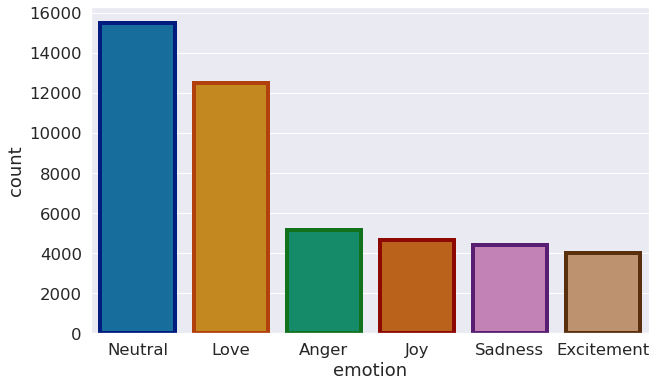

In [25]:
sns.set_style(style="darkgrid")
sns.set(font_scale=1.5)
plt.figure(figsize =(10, 6))

sns.countplot(df.emotion, palette='colorblind', order=df.emotion.value_counts().index, 
              linewidth=4, edgecolor=sns.color_palette("dark", 6))

#### Cleaned Corpus Wordcloud

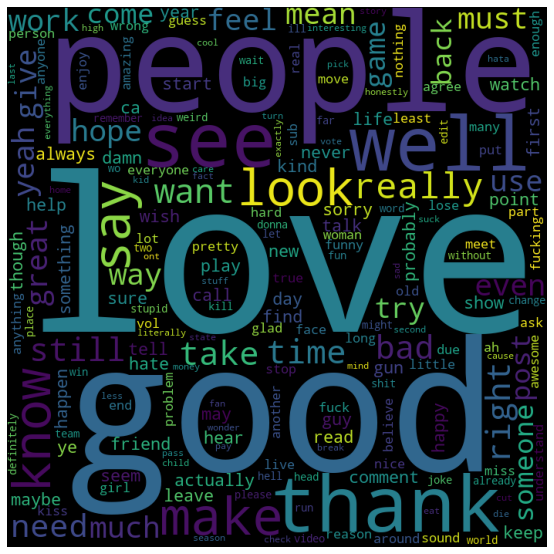

In [26]:
cleaned_corpus_wordcloud = create_word_cloud(cleaned_corpus)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(cleaned_corpus_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 1)
plt.show()

#### Most Common Words Graph

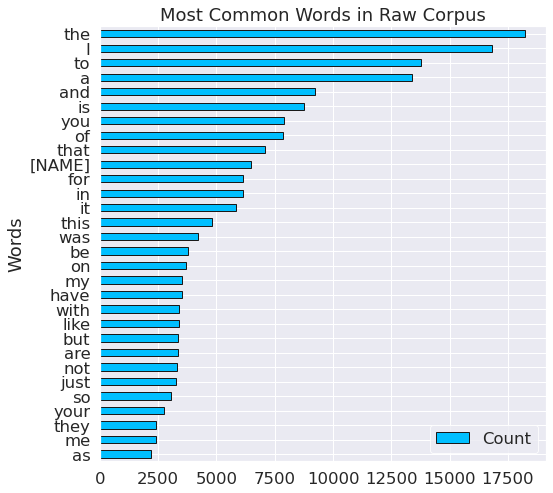

In [27]:
common_words_graph(raw_corpus, num_words=30, title='Most Common Words in Raw Corpus')

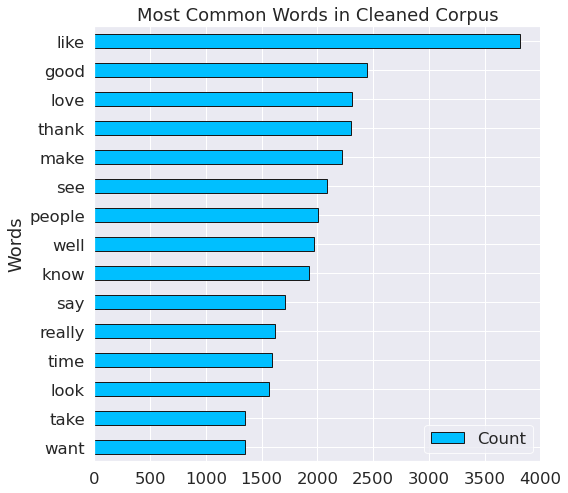

In [28]:
common_words_graph(cleaned_corpus, num_words=15, title='Most Common Words in Cleaned Corpus')

#### Word Count by Label

In [29]:
def word_count_by_label(label):
    comments = []

    a = df[df['emotion']==str(label)]
    for row in a.iterrows():
        for word in row[1]['comment'].split():
            comments.append(word)
    x = collections.Counter(comments)
    return x.most_common()

In [30]:
word_count_by_label('Excitement')

[('know', 300),
 ('like', 300),
 ('see', 239),
 ('make', 174),
 ('time', 174),
 ('people', 174),
 ('really', 157),
 ('say', 145),
 ('sure', 143),
 ('look', 138),
 ('even', 138),
 ('well', 130),
 ('still', 129),
 ('year', 123),
 ('never', 111),
 ('feel', 107),
 ('surprised', 106),
 ('take', 105),
 ('wonder', 104),
 ('mean', 104),
 ('right', 103),
 ('ca', 101),
 ('post', 97),
 ('good', 93),
 ('realize', 91),
 ('something', 89),
 ('yeah', 88),
 ('bad', 88),
 ('happen', 86),
 ('much', 84),
 ('understand', 82),
 ('wait', 82),
 ('want', 81),
 ('come', 81),
 ('excited', 80),
 ('day', 80),
 ('game', 78),
 ('work', 77),
 ('actually', 77),
 ('love', 76),
 ('believe', 73),
 ('way', 73),
 ('maybe', 72),
 ('new', 71),
 ('though', 71),
 ('use', 70),
 ('must', 69),
 ('someone', 68),
 ('first', 67),
 ('find', 67),
 ('watch', 67),
 ('could', 66),
 ('back', 65),
 ('try', 64),
 ('happy', 63),
 ('thank', 62),
 ('play', 60),
 ('many', 59),
 ('seem', 59),
 ('also', 57),
 ('guess', 57),
 ('read', 56),
 ('ide

#### Word Context Examples

In [31]:
word_context_examples(cleaned_corpus, 'people', lines=30)

Displaying 30 of 2004 matches:
 anything cook everyone laugh screw people instead actually dead fuck bayless 
n lucky proverbial phrase give idea people side want dead matter may stand cle
le apply increase bolt feature mean people debt see sense easy target hugging 
 find group play painless want know people like watch game genuinely baffle ap
ure piece shit interested know many people discriminate harass past kill scum 
e tournament blast meet really cool people love thank hold love someday yeah i
cal staff deluge always need ingest people also fairly regular opening medium 
ty pal reference feel like ont stop people bodily autonomy public health autho
 deal make fool concern depend many people awake pass time posting long crack 
uly amazing see straight understand people give gold crosspost deserve vote pr
y strong almost good stamp disgrace people money whisper steam hour start play
show propaganda effort simple blunt people need yet walk back support bill fin
ider normal intention

#### Lexical Diversity

In [32]:
lexical_diversity(raw_corpus)

Total words: 626456
Total unique words: 61143
Average word repetition: 6068.47
Proportion of unique words: 0.1


In [33]:
lexical_diversity(cleaned_corpus)

Total words: 277939
Total unique words: 18182
Average word repetition: 65485.41
Proportion of unique words: 0.07


# The Model

#### Train/Test Split

In [34]:
X = df['comment']
y = df['emotion']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

#### Vectorizer

In [36]:
tfv = TfidfVectorizer()

In [37]:
X_train = tfv.fit_transform(X_train).toarray()
X_test = tfv.transform(X_test).toarray()

In [ ]:
features = tfv.get_feature_names()
features

#### Grid Search

In [ ]:
xgb_default_params = XGBClassifier(n_jobs=-1)

In [ ]:
n_estimators = range(400, 800, 100)
learning_rate = [.3, .34]
max_depth = [3,5]

xgb_param_grid = {'n_estimators': n_estimators, 'learning_rate': learning_rate, 'max_depth': max_depth}

In [ ]:
grid_searcher(xgb_default_params, xgb, X_train, y_train, cv=5)

#### Fit and Score Model

In [38]:
xgb = XGBClassifier(n_estimators=400, learning_rate=.32, max_depth=5, n_jobs=-1)

In [39]:
fit_and_score_model(xgb, X_train, y_train, X_test, y_test)

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:31:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.5352036395147314
Precision: 0.5442854747587648
Recall: 0.5352036395147314
F1: 0.5146713622823639


# Error Analysis Matrices

In [40]:
preds = cross_val_predict(xgb, X_train, y_train, cv=5)
conf_mat = confusion_matrix(y_train, preds)
conf_mat

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:20:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:46:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:12:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:38:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:03:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([[1371,   90,  102,  357, 2060,  132],
       [ 142,  511,  119,  416, 1926,   79],
       [ 127,   61, 1544,  650, 1268,   87],
       [ 263,  124,  437, 5739, 3232,  178],
       [ 514,  269,  385, 1284, 9641,  302],
       [ 218,   71,  151,  392, 1915,  769]])

<function matplotlib.pyplot.show(close=None, block=None)>

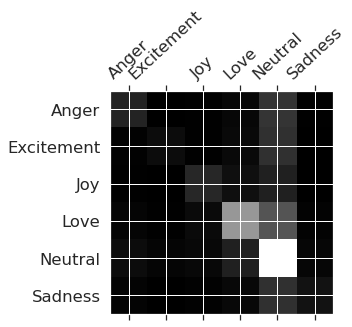

<Figure size 576x576 with 0 Axes>

In [41]:
ticks = [0,1,2,3,4,5]
labels = xgb.classes_

plt.matshow(conf_mat, cmap=plt.cm.gray)
plt.xticks(ticks, labels, rotation=43)
plt.yticks(ticks, labels, rotation=0)
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)
plt.show

In [42]:
row_sums = conf_mat.sum(axis=1, keepdims=True)
norm_conf_mat = conf_mat/row_sums

In [43]:
np.fill_diagonal(norm_conf_mat, 0)

<function matplotlib.pyplot.show(close=None, block=None)>

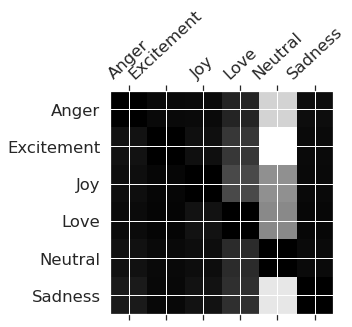

<Figure size 576x576 with 0 Axes>

In [44]:
plt.matshow(norm_conf_mat, cmap=plt.cm.gray)
plt.xticks(ticks, labels, rotation=43)
plt.yticks(ticks, labels, rotation=0)

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)
plt.show

# Comment Classifier

In [45]:
def comment_classifier(string):
    '''
    Prints the top three choices for which emotion (Anger, Excitement, Joy, Love, Neutral, or Sadness) the string is classified as and how certain the model is for each of those choices.

    Parameter
    ----------
    string:  str
        Text to classify.

    Returns
    ----------
       None.
    '''
    clean_text = text_cleaning_pipeline(string, StopWords)
    text_list = [clean_text]
    transformed = tfv.transform(text_list)
    probas = xgb.predict_proba(transformed)
    inds = np.argsort(probas[0])[::-1]
    
    if inds[:1] == 0:
        label_1 = 'Anger'
    if inds[:1] == 1:
        label_1 = 'Excitement'
    if inds[:1] == 2:
        label_1 = 'Joy'
    if inds[:1] == 3:
        label_1 = 'Love'
    if inds[:1] == 4:
        label_1 = 'Neutral'
    if inds[:1] == 5:
        label_1 = 'Sadness'
        
    if inds[1:2] == 0:
        label_2 = 'Anger'
    if inds[1:2] == 1:
        label_2 = 'Excitement'
    if inds[1:2] == 2:
        label_2 = 'Joy'
    if inds[1:2] == 3:
        label_2 = 'Love'
    if inds[1:2] == 4:
        label_2 = 'Neutral'
    if inds[1:2] == 5:
        label_2 = 'Sadness'
        
    if inds[2:3] == 0:
        label_3 = 'Anger'
    if inds[2:3] == 1:
        label_3 = 'Excitement'
    if inds[2:3] == 2:
        label_3 = 'Joy'
    if inds[2:3] == 3:
        label_3 = 'Love'
    if inds[2:3] == 4:
        label_3 = 'Neutral'
    if inds[2:3] == 5:
        label_3 = 'Sadness'

    confidence_level_1 = probas[0][inds[:1]][0]
    confidence_level_2 = probas[0][inds[1:2]][0]
    confidence_level_3 = probas[0][inds[2:3]][0]
    
    print(f'Class: {label_1}.  Certainty: {confidence_level_1}%.\n')
    print(f'Class: {label_2}.  Certainty: {confidence_level_2}%.\n')
    print(f'Class: {label_3}.  Certainty: {confidence_level_3}%.')

In [47]:
comment_classifier('I wonder how Ben will help us.  I cant wait to hire him!')

Class: Excitement.  Certainty: 0.5097938776016235%.

Class: Neutral.  Certainty: 0.2787089943885803%.

Class: Love.  Certainty: 0.1457275003194809%.
